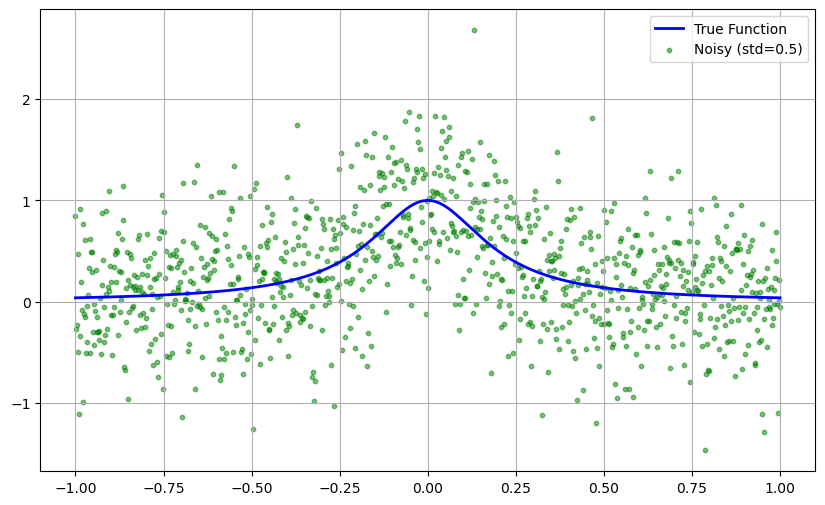

In [ ]:
from data import generate_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

n = 1000

x, y, y_noisy = generate_dataset(n=n, noise_std=0.5, random_state=1)

plt.figure(figsize=(10, 6))
plt.plot(x, y, color="blue", linewidth=2, label="True Function")
plt.scatter(x, y_noisy, s=10, color="green", alpha=0.5, label="Noisy (std=0.5)")
plt.legend()
plt.grid()
plt.show()

In [8]:
def ReLU(z):
    return np.where(z > 0, z, 0)

def leaky_ReLU(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dsigmoid(a):
    return a * (1 - a)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=42)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def sgd_adam(X_train, y_train, X_test, y_test, layers=[1,10,1], eta=0.01, num_steps=1000,
             beta1=0.9, beta2=0.999, eps=1e-8, batch_size=32, seed=0):
    
    rng = np.random.default_rng(seed)
    n, d = X_train.shape
    # --- initialize weights ---
    W, b = [], []
    for i in range(len(layers)-1):
        W.append(rng.normal(0, 1/np.sqrt(layers[i]), (layers[i], layers[i+1])))
        b.append(np.zeros((1, layers[i+1])))
    # --- initialize Adam params ---
    mW = [np.zeros_like(w) for w in W]
    vW = [np.zeros_like(w) for w in W]
    mb = [np.zeros_like(bb) for bb in b]
    vb = [np.zeros_like(bb) for bb in b]

    mse_train, mse_test = [], []
    
    for t in range(1, num_steps+1):
        idx = rng.choice(n, batch_size, replace=False)
        Xb, yb = X_train[idx], y_train[idx]
        
        # --- forward ---
        A = [Xb]
        for i in range(len(W)-1):
            Z = A[-1] @ W[i] + b[i]
            A.append(sigmoid(Z))
        ZL = A[-1] @ W[-1] + b[-1]   # linear output
        yhat = ZL

        # --- backward ---
        dZ = 2.0*(yhat - yb)/batch_size
        dW, db = [None]*len(W), [None]*len(W)
        dW[-1] = A[-1].T @ dZ
        db[-1] = np.sum(dZ, axis=0, keepdims=True)
        dA = dZ @ W[-1].T
        for i in range(len(W)-2, -1, -1):
            dZ = dA * dsigmoid(A[i+1])
            dW[i] = A[i].T @ dZ
            db[i] = np.sum(dZ, axis=0, keepdims=True)
            if i > 0:
                dA = dZ @ W[i].T

        # --- Adam update ---
        for i in range(len(W)):
            mW[i] = beta1*mW[i] + (1-beta1)*dW[i]
            vW[i] = beta2*vW[i] + (1-beta2)*(dW[i]**2)
            mb[i] = beta1*mb[i] + (1-beta1)*db[i]
            vb[i] = beta2*vb[i] + (1-beta2)*(db[i]**2)
            mW_hat = mW[i] / (1 - beta1**t)
            vW_hat = vW[i] / (1 - beta2**t)
            mb_hat = mb[i] / (1 - beta1**t)
            vb_hat = vb[i] / (1 - beta2**t)
            W[i] -= eta * mW_hat / (np.sqrt(vW_hat) + eps)
            b[i] -= eta * mb_hat / (np.sqrt(vb_hat) + eps)

        def forward(X):
            A = X
            for i in range(len(W)-1):
                A = sigmoid(A @ W[i] + b[i])
            return A @ W[-1] + b[-1]
        mse_train.append(mse(y_train, forward(X_train)))
        mse_test.append(mse(y_test, forward(X_test)))

    return W, b, mse_train, mse_test


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

W, b, mse_tr, mse_te = sgd_adam(x_train_scaled, y_train, x_test_scaled, y_test, 
                                 layers=[1,10,1], eta=0.01, num_steps=2000)

print("Final test MSE:", mse_te[-1])


Final test MSE: 0.23056791995527312


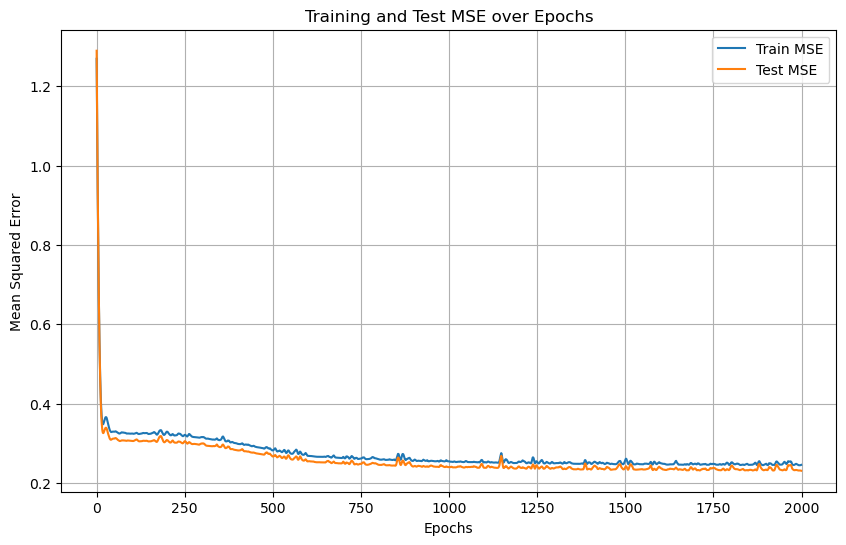

In [11]:
plt.figure(figsize=(10,6))
plt.plot(mse_tr, label="Train MSE")
plt.plot(mse_te, label="Test MSE")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training and Test MSE over Epochs")
plt.legend()
plt.grid(True)
plt.show()


Layers=0, nodes=5 -> Test MSE=0.30792
Layers=0, nodes=10 -> Test MSE=0.30792
Layers=0, nodes=25 -> Test MSE=0.30792
Layers=0, nodes=50 -> Test MSE=0.30792
Layers=1, nodes=5 -> Test MSE=0.23008
Layers=1, nodes=10 -> Test MSE=0.23099
Layers=1, nodes=25 -> Test MSE=0.23323
Layers=1, nodes=50 -> Test MSE=0.23683
Layers=2, nodes=5 -> Test MSE=0.23088
Layers=2, nodes=10 -> Test MSE=0.23123
Layers=2, nodes=25 -> Test MSE=0.23296
Layers=2, nodes=50 -> Test MSE=0.23280
Layers=3, nodes=5 -> Test MSE=0.23051
Layers=3, nodes=10 -> Test MSE=0.22992
Layers=3, nodes=25 -> Test MSE=0.23145
Layers=3, nodes=50 -> Test MSE=0.23588


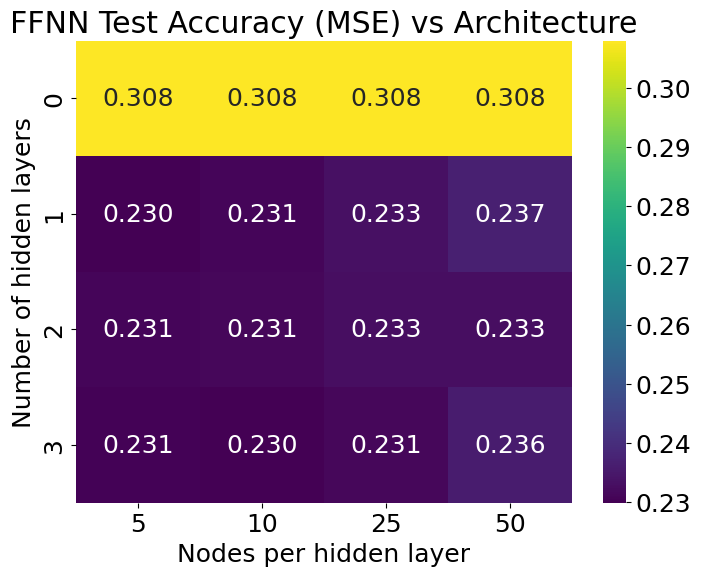

In [16]:
import seaborn as sns

hidden_layers_list = [0, 1, 2, 3]
nodes_list = [5, 10, 25, 50]

results = np.zeros((len(hidden_layers_list), len(nodes_list)))

for i, n_layers in enumerate(hidden_layers_list):
    for j, n_nodes in enumerate(nodes_list):
        # build layer structure dynamically
        if n_layers == 0:
            layers = [1, 1]              # no hidden layer = linear
        else:
            layers = [1] + [n_nodes]*n_layers + [1]
        
        # train network
        W, b, mse_tr, mse_te = sgd_adam(x_train_scaled, y_train, x_test_scaled, y_test,
                                        layers=layers, eta=0.01, num_steps=1500, seed=1)
        results[i, j] = mse_te[-1]  # store final test MSE
        print(f"Layers={n_layers}, nodes={n_nodes} -> Test MSE={mse_te[-1]:.5f}")

# Optionally convert to "accuracy-like" by inverting
acc_matrix = results

# --- Plot heatmap ---
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
sns.heatmap(acc_matrix, annot=True, fmt=".3f", cmap="viridis",
            xticklabels=nodes_list, yticklabels=hidden_layers_list)
plt.xlabel("Nodes per hidden layer")
plt.ylabel("Number of hidden layers")
plt.title("FFNN Test Accuracy (MSE) vs Architecture")
plt.show()


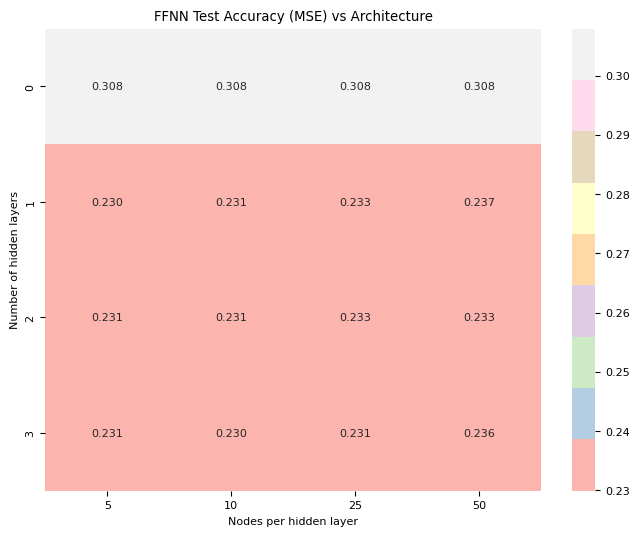

In [18]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,6))
sns.heatmap(acc_matrix, annot=True, fmt=".3f", cmap="Pastel1",
            xticklabels=nodes_list, yticklabels=hidden_layers_list)
plt.xlabel("Nodes per hidden layer")
plt.ylabel("Number of hidden layers")
plt.title("FFNN Test Accuracy (MSE) vs Architecture")
plt.show()